In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

C:\Users\rayja\anaconda3\envs\python3816\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rayja\anaconda3\envs\python3816\lib\site-packages\numpy\.libs\libopenblas.4sp5sua7cbgxueoc35yp2asoicyyeqzz.gfortran-win_amd64.dll
C:\Users\rayja\anaconda3\envs\python3816\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\rayja\anaconda3\envs\python3816\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\rayja\anaconda3\envs\python3816\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Define the paths for images and masks
image_path = 'Road Segmentation Dataset/images'
mask_path = 'Road Segmentation Dataset/masks'

In [3]:
#img_w, img_h = 64, 64
img_w, img_h = 1280, 720

In [4]:
def normalze(img):
    #return img/255.
    return img

# Step 1: Load and Preprocess Images
First, we'll load the RGB images and their corresponding masks, resize them to 64x64 pixels, and convert them to RGB format.

In [5]:
# Lists to store the preprocessed images and masks
preprocessed_images = []
preprocessed_masks = []

# Load and preprocess images
for i in range(31):
    # Load the image and mask
    rgb_image = cv2.imread(os.path.join(image_path, f'{i}.png'))
    mask_image = cv2.imread(os.path.join(mask_path, f'{i}.png'))
    
    # Resize to 64x64
    rgb_image = cv2.resize(rgb_image, (img_w, img_h))
    mask_image = cv2.resize(mask_image, (img_w, img_h))

    # Convert both to RGB
    rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
    
    # normalize rgb image
    rgb_image = normalze(rgb_image)
    
    # Store the preprocessed images and masks
    preprocessed_images.append(rgb_image)
    preprocessed_masks.append(mask_image)

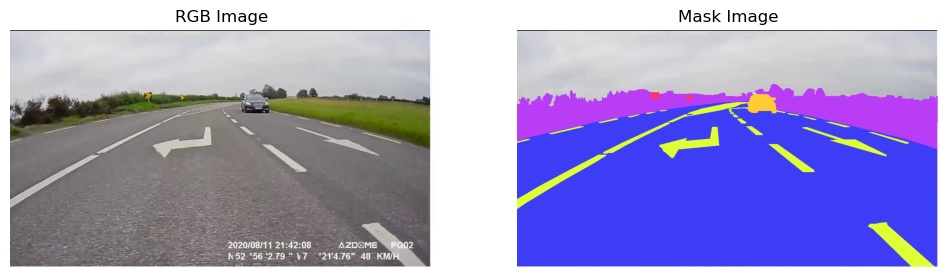

In [6]:
# Display the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(preprocessed_images[0])
plt.title('RGB Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_masks[0])
plt.title('Mask Image')
plt.axis('off')

plt.show()

# Step 2: Encode Masks
After loading and preprocessing the images, we'll encode the masks

In [7]:
def encode_mask(mask, class_colors):
    encoded = np.full(mask.shape[:2], len(class_colors), dtype=int)  # Default to background
    for class_id, color in enumerate(class_colors.values()):
        encoded[np.where((mask == color).all(axis=2))] = class_id
    return encoded

In [8]:
# RGB values for known classes
class_colors = {
    "road_surface": (61, 61, 245),
    "marking": (221, 255, 51),
    "road_sign": (255, 53, 94),
    "car": (255, 204, 51)
}

In [9]:
# List to store encoded masks
encoded_masks = []

# Encode each mask
for mask in preprocessed_masks:
    encoded_mask = encode_mask(mask, class_colors)
    encoded_masks.append(encoded_mask)

In [10]:
temp_mask = encoded_masks[0]

In [11]:
temp_mask.shape

(720, 1280)

In [12]:
# Define a new color map for visualization (RGB colors)
new_color_map = {
    0: (255, 0, 0),     # Red for road_surface
    1: (0, 255, 0),     # Green for marking
    2: (0, 0, 255),     # Blue for road_sign
    3: (255, 255, 0),   # Yellow for car
    4: (255, 0, 255)    # Magenta for background
}

In [13]:
def labels_to_rgb(mask, color_map):
    """
    Converts a mask with class labels to an RGB image using a specified color map.

    Args:
    - mask (numpy.ndarray): A 2D array where each element is a class label.
    - color_map (dict): A dictionary mapping class labels to RGB color tuples.

    Returns:
    - numpy.ndarray: An RGB image representing the mask.
    """
    rgb_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_id, color in color_map.items():
        rgb_mask[mask == class_id] = color
    return rgb_mask

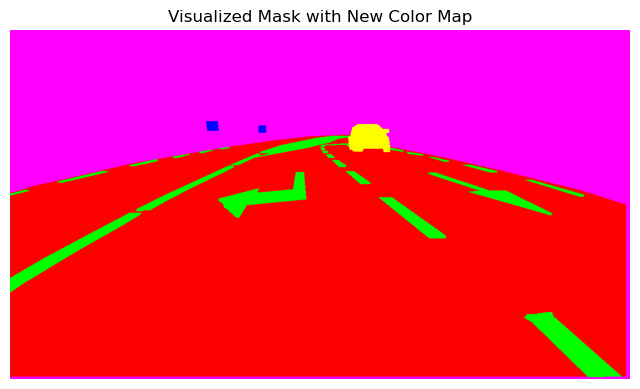

In [14]:
# Create an RGB image from the encoded mask using the new color map
visual_mask = labels_to_rgb(temp_mask, new_color_map)

# Display the visual mask
plt.figure(figsize=(8, 8))
plt.imshow(visual_mask)
plt.title('Visualized Mask with New Color Map')
plt.axis('off')
plt.show()

## Equal Sample Rate Pixel Sampling for SVM Training

To improve the efficiency of SVM training for image segmentation and address potential class imbalances, an equal sample rate strategy can be employed. This approach ensures a balanced dataset by sampling an equal number of pixels from each class.

### Steps for Implementation

1. **Collect Pixels by Class**:
   - Separate the pixels in the dataset by their class labels.

2. **Determine Minimum Number of Pixels**:
   - Find the class with the least number of pixels.
   - This count becomes the baseline for sampling from all classes.

3. **Sample Pixels Equally from Each Class**:
   - From each class, randomly sample a number of pixels equal to the determined minimum.

4. **Prepare the Training Dataset**:
   - Combine these equally sampled pixels to create a balanced training dataset.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
preprocessed_images = np.stack(preprocessed_images, axis=0)
encoded_masks = np.stack(encoded_masks, axis=0)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_images, encoded_masks, test_size=0.2, random_state=42)

In [19]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (24, 720, 1280, 3)
Shape of y_train: (24, 720, 1280)
Shape of X_test: (7, 720, 1280, 3)
Shape of y_test: (7, 720, 1280)


In [20]:
# Assuming preprocessed_images and encoded_masks are already defined and processed
#X_train = np.vstack([img.reshape(-1, 3) for img in X_train])  # Flatten each image to a list of RGB pixels
#y_train = np.hstack([mask.flatten() for mask in y_train])  # Flatten each mask
#X_test = np.vstack([img.reshape(-1, 3) for img in X_test])  # Flatten each image to a list of RGB pixels
#y_test = np.hstack([mask.flatten() for mask in y_test])  # Flatten each mask

In [21]:
pixel_counts = np.bincount(y_train.flatten())

print("In training data: ")
for class_id, count in enumerate(pixel_counts):
    print(f"Class {class_id} has {count} pixels")

In training data: 
Class 0 has 12153199 pixels
Class 1 has 364178 pixels
Class 2 has 98461 pixels
Class 3 has 152766 pixels
Class 4 has 9349796 pixels


In [22]:
pixel_counts = np.bincount(y_test.flatten())

print("In testing data: ")
for class_id, count in enumerate(pixel_counts):
    print(f"Class {class_id} has {count} pixels")

In testing data: 
Class 0 has 3517398 pixels
Class 1 has 91242 pixels
Class 2 has 33620 pixels
Class 3 has 7072 pixels
Class 4 has 2801868 pixels


In [23]:
def sample_pixels_randomly(X, y, num_classes=5, sample_fraction=None, sample_pixel_number=None):
    """
    Randomly samples pixels from each class with either a fraction or a fixed number of pixels.
    Raises an error if the requested number of pixels exceeds the available pixels in any class.

    Args:
    - X (numpy.ndarray): image data.
    - y (numpy.ndarray): Corresponding class labels.
    - num_classes (int): Number of classes.
    - sample_fraction (float, optional): Fraction of pixels to sample from each class.
    - sample_pixel_number (int, optional): Fixed number of pixels to sample from each class.

    Returns:
    - (numpy.ndarray, numpy.ndarray): Sampled image data and labels.
    """
    sampled_X = []
    sampled_y = []
    
    X = np.vstack([img.reshape(-1, 3) for img in X])
    y = np.hstack([mask.flatten() for mask in y])

    for class_id in range(num_classes):
        # Extract pixels for the current class
        class_pixels = X[y == class_id]

        # Determine number of samples
        if sample_fraction is not None:
            num_samples = int(len(class_pixels) * sample_fraction)
        elif sample_pixel_number is not None:
            #if sample_pixel_number > len(class_pixels):
                #raise ValueError(f"Requested number of pixels ({sample_pixel_number}) exceeds available pixels in class {class_id}.")
            #num_samples = sample_pixel_number
            num_samples = min(sample_pixel_number, len(class_pixels))
        else:
            raise ValueError("Either sample_fraction or sample_pixel_number must be provided.")

        # Random sampling
        sampled_indices = np.random.choice(len(class_pixels), num_samples, replace=False)
        sampled_X.append(class_pixels[sampled_indices])
        sampled_y.extend([class_id] * num_samples)

    return np.vstack(sampled_X), np.array(sampled_y)

In [24]:
clf = svm.SVC(kernel='linear')

In [25]:
num_iterations = 10  # Number of times to repeat the training process

acc_list = []
for i in range(num_iterations):
    # Sample the pixels
    sampled_X_train, sampled_y_train = sample_pixels_randomly(X_train, y_train, sample_pixel_number=512)
    #sampled_X_train, sampled_y_train = sample_pixels_randomly(X_train, y_train, sample_fraction = 0.2)
    
    print("Shape of sampled_X:", sampled_X_train.shape)
    print("Shape of sampled_y:", sampled_y_train.shape)
    #print(sampled_X_train)
    #print(sampled_y_train)
    
    pixel_counts = np.bincount(sampled_y_train)
    for class_id, count in enumerate(pixel_counts):
        print(f"Class {class_id}: {count} pixels")
    
    # train the SVM    
    print("Training...")
    clf.fit(sampled_X_train, sampled_y_train)

    # Evaluate the model
    print("Evaluating...")
    sampled_X_test, sampled_y_test = sample_pixels_randomly(X_test, y_test, sample_pixel_number=512)
    #sampled_X_test, sampled_y_test = sample_pixels_randomly(X_test, y_test,  sample_fraction = 0.2)
    
    pixel_counts = np.bincount(sampled_y_test)
    for class_id, count in enumerate(pixel_counts):
        print(f"Class {class_id}: {count} pixels")
        
    y_pred = clf.predict(sampled_X_test)
    accuracy = accuracy_score(sampled_y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print("--------------------------------------")
    acc_list.append(accuracy)

Shape of sampled_X: (2560, 3)
Shape of sampled_y: (2560,)
Class 0: 512 pixels
Class 1: 512 pixels
Class 2: 512 pixels
Class 3: 512 pixels
Class 4: 512 pixels
Training...
Evaluating...
Class 0: 512 pixels
Class 1: 512 pixels
Class 2: 512 pixels
Class 3: 512 pixels
Class 4: 512 pixels
Accuracy: 0.65
--------------------------------------
Shape of sampled_X: (2560, 3)
Shape of sampled_y: (2560,)
Class 0: 512 pixels
Class 1: 512 pixels
Class 2: 512 pixels
Class 3: 512 pixels
Class 4: 512 pixels
Training...
Evaluating...
Class 0: 512 pixels
Class 1: 512 pixels
Class 2: 512 pixels
Class 3: 512 pixels
Class 4: 512 pixels
Accuracy: 0.65
--------------------------------------
Shape of sampled_X: (2560, 3)
Shape of sampled_y: (2560,)
Class 0: 512 pixels
Class 1: 512 pixels
Class 2: 512 pixels
Class 3: 512 pixels
Class 4: 512 pixels
Training...
Evaluating...
Class 0: 512 pixels
Class 1: 512 pixels
Class 2: 512 pixels
Class 3: 512 pixels
Class 4: 512 pixels
Accuracy: 0.63
-------------------------

# Predict on testing images

In [26]:
# Create a legend for the color map
legend_handles = [mpatches.Patch(color=np.array(color)/255.0, label=class_name) 
                  for class_name, color in zip(['Road Surface', 'Marking', 'Road Sign', 'Car', 'Background'], new_color_map.values())]

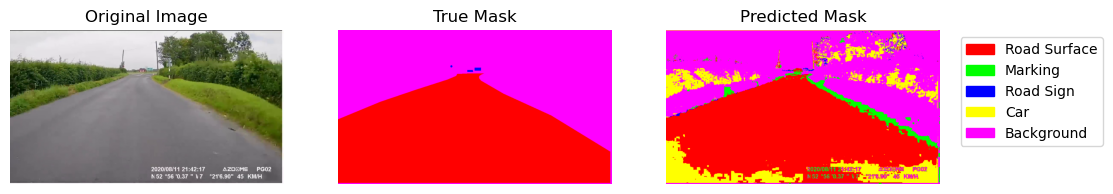

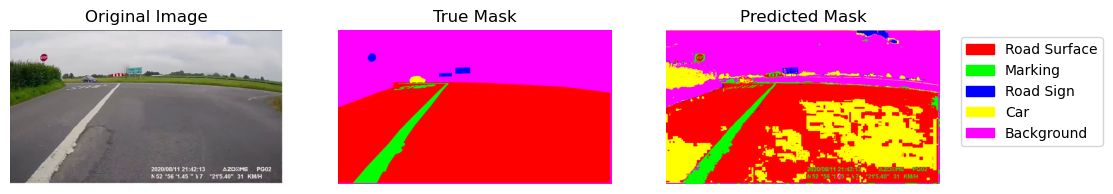

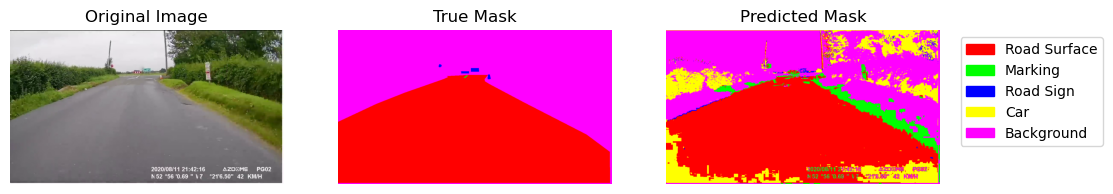

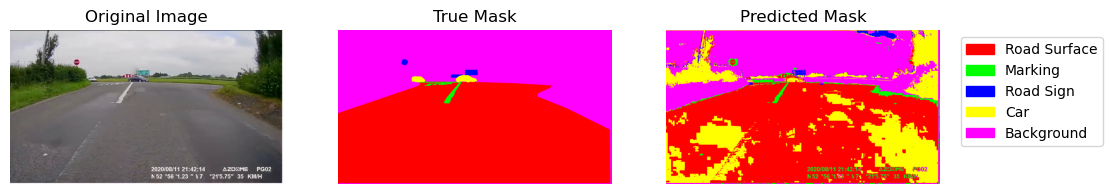

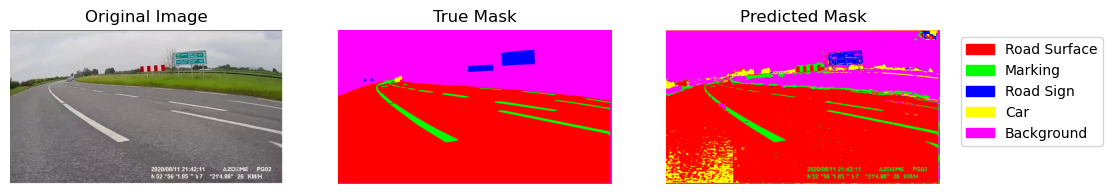

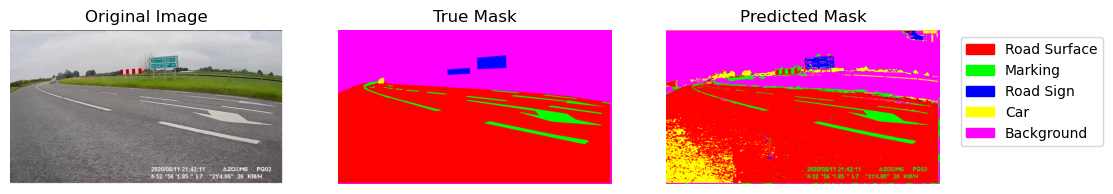

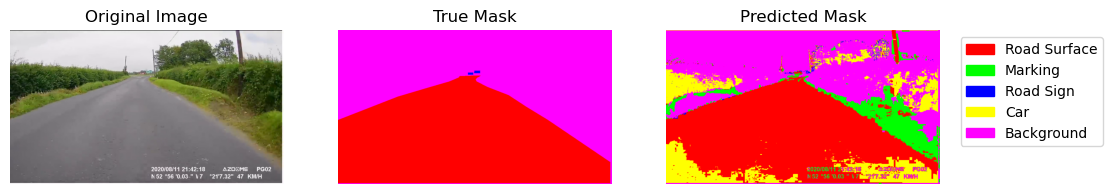

In [29]:
# Number of images to display
#num_images_to_show = 7

# Randomly select a few images from the test set
#test_indices = np.random.choice(X_test.shape[0], num_images_to_show, replace=False)

#for idx in test_indices:
for idx in range(X_test.shape[0]):
    # Extract and reshape the flattened image and mask
    test_img = X_test[idx]
    test_img = cv2.resize(test_img, (img_w, img_h))
    flattened_image = test_img.reshape(-1, 3)
    true_mask = y_test[idx]

    # Predict the mask
    predicted_mask_flat = clf.predict(flattened_image)
    predicted_mask = predicted_mask_flat.reshape(img_h, img_w)

    # Convert label masks to RGB
    true_mask_rgb = labels_to_rgb(true_mask, new_color_map)
    predicted_mask_rgb = labels_to_rgb(predicted_mask, new_color_map)

    # Visualize the original image, true mask, and predicted mask
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(test_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask_rgb)
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask_rgb)
    plt.title("Predicted Mask")
    plt.axis('off')
    
    # Add the legend
    plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()